# SimpleCNN

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical  # 원핫인코딩을 할 거다

## Kaggle 데이터 불러오기
- csv 파일은 pandas로 먼저 불러오자
- 일단 지금까지 `train`, `test`는 pandas DataFrame

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

- 항상 shape를 먼저 찍어보자!
- ndarray 아니고 DataFrame이긴 한데, 여기도 shape가 있다.

In [3]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


- `train`은 42000행, 785열짜리 데이터.
- 맨 앞 column에 label 하나 붙고, 픽셀 784개 뒤따라 붙는다. 그래서 column 785개
- 이미지는 총 42000개

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- `test`는 28000행 784열
- 레이블 없이 그냥 784픽셀 이미지만 28000개

In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## csv로 불러온 DataFrame을 ndarray로 변환, 데이터 정규화
- `train`을 `train_images`, `train_labels`로, `test`를 `test_images`로 변환할 것.
- 차원도 맞추고, 정규화도 하고...

- `DataFrame.drop` : 해당 이름의 행/열을 삭제.
- `axis=1`이면 axis=1이면 y축을 기준으로 하므로 열 삭제.
- 거기다가 `values`를 취하면 ndarray로 값만 튀어나온다

> reshape를 할 때 [-1, 28, 28, 1]은 [batch_size, width, height, channel] 을 의미한다.
> batch_size를 -1로 두면 자동으로 batch_size를 조정하겠다는 뜻이다.
> 따라서 파이프라인을 변경해서 batch size를 변경해야 하더라도 reshape의 batch size 크기를 바꿔줄 필요가 없게 된다.

- 늘 하던 대로 0~1 사이 실수값이 되도록 정규화도 해 준다

In [6]:
train_images = train.drop('label', axis=1).values
train_images = train_images.reshape((-1, 28, 28, 1))
train_images = train_images.astype('float32') / 255
train_images.shape

(42000, 28, 28, 1)

- `DataFrame['칼럼명']` 으로 열 하나를 가져올 수 있다.
  - `DataFrame.loc[:, '칼럼명']` 도 똑같다
  - 나중에 `DataFrame.loc` 사용법 알아볼 것
- 가져와서 one-hot encoding도 해 주자

In [7]:
train_labels = to_categorical(train['label'])
train_labels.shape

(42000, 10)

- `test_images`도 똑같이 해 주자

In [8]:
test_images = test.values
test_images = test_images.reshape((-1, 28, 28, 1))
test_images = test_images.astype('float32') / 255
test_images.shape

(28000, 28, 28, 1)

## Model 구성 및 컴파일, 훈련
- 우선 Convolution 레이어랑 Max Pooling 레이어들을 쭉 쌓고, Flatten해서 Dense 한 번, 마지막에 분류용 softmax 먹인 10개짜리 Dense 한 번.

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

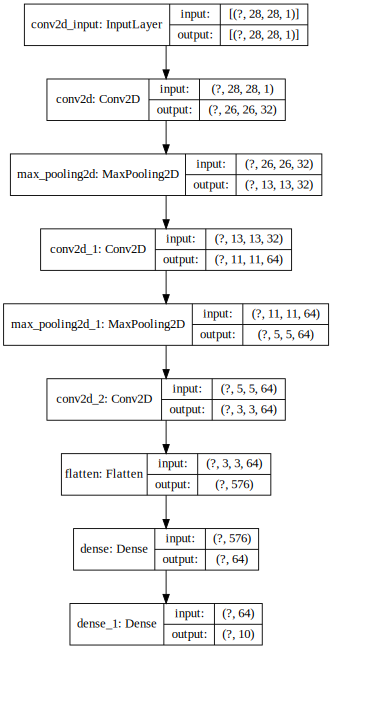

In [11]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
657/657 [==============================] - 12s 18ms/step - loss: 0.2173 - accuracy: 0.93 - ETA: 2s - loss: 0.2616 - accuracy: 0.91 - ETA: 0s - loss: 0.2282 - accuracy: 0.92
Epoch 2/5
657/657 [==============================] - 13s 19ms/step - loss: 0.0561 - accuracy: 0.98 - ETA: 12s - loss: 0.0682 - accuracy: 0.97 - ETA: 9s - loss: 0.0663 - accuracy: 0.97
Epoch 3/5
657/657 [==============================] - 13s 20ms/step - loss: 0.0381 - accuracy: 0.988 - ETA: 5s - loss: 0.0370 - accuracy: 0.98 - ETA: 4s - loss: 0.0379 - accuracy: 0.98 - ETA: 1s - loss: 0.0377 - accuracy: 0.98
Epoch 4/5
657/657 [==============================] - 13s 20ms/step - loss: 0.0281 - accuracy: 0.99 - ETA: 5s - loss: 0.0282 - accuracy: 0.99 - ETA: 1s - loss: 0.0286 - accuracy: 0.99
Epoch 5/5
657/657 [==============================] - 14s 21ms/step - loss: 0.0226 - accuracy: 0.99 - ETA: 0s - loss: 0.0227 - accuracy: 0.99


## 훈련된 Model을 이용해서 예측
- `test_images` 넣어서 우리가 원하는 `test_labels`를 뽑아보자

In [13]:
test_labels = model.predict(test_images)
test_labels.shape

(28000, 10)

- Kaggle에 submission할 때, 결과값은 원 핫 벡터가 아니라 0~9 숫자 하나여야 한다.
- `test_labels`의 각 행은 각 숫자에 해당하는 확률값을 담은 길이 10짜리 벡터이다.
- `ndarray.argmax` : axis에 해당하는 값들 중 가장 큰 값의 인덱스들을 반환
  - `axis=1` : y축 기준 쭉 내려가면서 큰 값의 인덱스들만 남긴다
- 확률 가장 큰 애의 인덱스가 그 숫자니까 이렇게 하면 됨

In [14]:
pred = test_labels.argmax(axis=1)
pred.shape

(28000,)

## Submission!
```
Your submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:

ImageId,Label
1,3
2,7
3,8
(27997 more lines)
```

- 잘 알아서 DataFrame으로 만들고 csv로 만들어서 내자
- to_csv에서, `index=False` 안 하면 기본적으로 index 칼럼이 하나 더 생긴다

In [15]:
submission = pd.DataFrame({
    "ImageId": range(1, 28001),
    "Label": pred
})
submission.to_csv('../output/SimpleCNN_submission.csv', index=False)